## Installations needed for Erda to work

In [29]:
!pip install -U pip tensorflow tensorboard mediapipe tensorflow plotly scikeras tensorrt scikeras

  Using cached tensorboard-2.13.0-py3-none-any.whl (5.6 MB)


In [52]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd


# Used to create training and testing data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Used for Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten
from tensorflow.keras.callbacks import TensorBoard

#Used for parameter tuning
from tensorflow import keras
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

#For accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 1. Importing and Splitting Data

In [31]:
X = np.load('../export_data/X_dataVR.npy')
y = np.load('../export_data/y_dataVR.npy')


In [32]:
print(X.shape)

(213, 120, 144)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=6*y.shape[1], stratify=y, random_state=40)
X.shape


(213, 120, 144)

In [34]:
for i in range (y_train.shape[1]):
    print("Number of words in " + str(i) + " category: " + str(np.count_nonzero(y_test[:,i])))

Number of words in 0 category: 6
Number of words in 1 category: 4
Number of words in 2 category: 7
Number of words in 3 category: 5
Number of words in 4 category: 5
Number of words in 5 category: 8
Number of words in 6 category: 7
Number of words in 7 category: 6
Number of words in 8 category: 6


# 2. Neural Network Implementation

### Saving Logs

In [35]:
tracing_logs = TensorBoard(os.path.join('Logs'))

### LSTM Implementation

In [36]:
def create_model(neurons):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, activation='relu', input_shape=(120,144)))
    model.add(Flatten())
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model

model = KerasClassifier(model=create_model, loss='categorical_crossentropy', verbose=0)

In [37]:
neurons = [8, 16, 32, 64]
learn_rate = [0.001, 0.01, 0.1]
epochs = [50, 100]
param_grid = dict(model__neurons=neurons, optimizer__learning_rate=learn_rate, epochs=epochs)
search = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, verbose = 0)

search.fit(X_train, np.argmax(y_train, axis=1))

/opt/conda/envs/python3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/envs/python3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/envs/python3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/envs/python3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in vers

GridSearchCV(cv=5,
             estimator=KerasClassifier(loss='categorical_crossentropy', model=<function create_model at 0x7f120db648b0>, verbose=0),
             param_grid={'epochs': [50, 100], 'model__neurons': [8, 16, 32, 64],
                         'optimizer__learning_rate': [0.001, 0.01, 0.1]})

In [38]:
search.best_score_

0.9493951612903226

In [39]:
search.best_params_

{'epochs': 100, 'model__neurons': 16, 'optimizer__learning_rate': 0.01}

In [53]:
model = Sequential()
model.add(LSTM(16, return_sequences=True, activation='relu', input_shape=(120,144)))
model.add(Flatten())
model.add(Dense(y.shape[1], activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, epochs = 100, callbacks = [tracing_logs])


Epoch 1/100
5/5 [==============================] - 1s 37ms/step - loss: 2.0813 - categorical_accuracy: 0.3459
Epoch 2/100
5/5 [==============================] - 0s 38ms/step - loss: 0.9223 - categorical_accuracy: 0.6415
Epoch 3/100
5/5 [==============================] - 0s 37ms/step - loss: 0.4885 - categorical_accuracy: 0.8113
Epoch 4/100
5/5 [==============================] - 0s 36ms/step - loss: 0.2909 - categorical_accuracy: 0.9371
Epoch 5/100
5/5 [==============================] - 0s 38ms/step - loss: 1.1355 - categorical_accuracy: 0.9119
Epoch 6/100
5/5 [==============================] - 0s 37ms/step - loss: 0.1986 - categorical_accuracy: 0.9245
Epoch 7/100
5/5 [==============================] - 0s 39ms/step - loss: 0.1867 - categorical_accuracy: 0.9497
Epoch 8/100
5/5 [==============================] - 0s 37ms/step - loss: 0.1311 - categorical_accuracy: 0.9686
Epoch 9/100
5/5 [==============================] - 0s 37ms/step - loss: 283085.7500 - categorical_accuracy: 0.9182
Epoch

# 3. Visualizing Epoch progress of NN

Train: 0.995


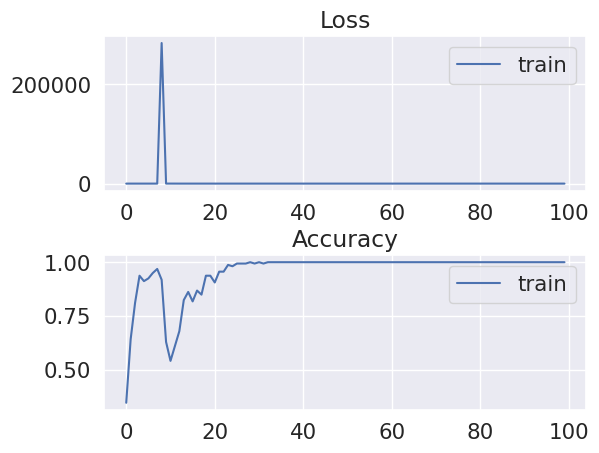

In [65]:
# evaluate the model
_, train_acc = model.evaluate(X, y, verbose=0)
print('Train: %.3f' % (train_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.tight_layout(pad=1.0)
plt.title('Accuracy')
plt.plot(history.history['categorical_accuracy'], label='train')
plt.legend()
plt.savefig('MediapipeAccuracyPlot.png')

# 3. Saving complete NN model

In [66]:
model.save('../export_data/nn_model.h5')
np.save('../export_data/X_test', X_test)
np.save('../export_data/y_test', y_test)
np.save('../export_data/X_train', X_train)
np.save('../export_data/y_train', y_train)

In [67]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, tf.argmax(y_pred, axis=1)))

2/2 [==============================] - 0s 11ms/step
Accuracy: 0.9814814814814815
